# Titanic - Machine Learning from Disaster

## Overview

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, the goal is to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Problem Definition

> what sorts of people were more likely to survive?

### Data

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set was used to build the machine learning models. For the training set, it provides the outcome (also known as the “ground truth”) for each passenger. The model was based on “features” like passengers’ gender and class. 

The test set was used to see how well the model performed on unseen data. For each passenger in the test set, the model was trained to predict whether or not they survived the sinking of the Titanic.

Also includes is the gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what the submission file should look like.

For more details, checkout the [data dictionary](https://www.kaggle.com/competitions/titanic/data)

### Evaluation

> The score is the percentage of passengers the model correctly predicted. This is known as accuracy.

### Features
#### Data Analysis EDA

In [580]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.metrics import accuracy_score 
from sklearn.svm import LinearSVC 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedKFold 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
import optuna as opt
import xgboost as xgb
import catboost as cat
%matplotlib inline

In [447]:
# load training data 
dff = pd.read_csv('data/train.csv')
dff.sample(frac=.2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
239,240,0,2,"Hunt, Mr. George Henry",male,33.00,0,0,SCO/W 1585,12.2750,NaN,S
315,316,1,3,"Nilsson, Miss. Helmina Josefina",female,26.00,0,0,347470,7.8542,NaN,S
50,51,0,3,"Panula, Master. Juha Niilo",male,7.00,4,1,3101295,39.6875,NaN,S
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S
...,...,...,...,...,...,...,...,...,...,...,...,...
437,438,1,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24.00,2,3,29106,18.7500,NaN,S
278,279,0,3,"Rice, Master. Eric",male,7.00,4,1,382652,29.1250,NaN,Q
689,690,1,1,"Madill, Miss. Georgette Alexandra",female,15.00,0,1,24160,211.3375,B5,S
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.00,1,0,PC 17485,56.9292,A20,C


In [448]:
# drop `PassengerID`
df = dff.drop('PassengerId', axis=1)

In [450]:
# quick overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


Note: 
- There are 891 samples/rows and 12 columns/varibles (11 features, 1 label).
- There are some non-numeric features.
- Based on the total number of rows there are some missing values in some features like `Age`, `Cabin`...

In [451]:
# check dimension of data
df.shape 

(891, 11)

In [452]:
# check that labels have only 2 unique values
df.Survived.value_counts() 

Survived
0    549
1    342
Name: count, dtype: int64

In [453]:
# quick descriptive statistics
df.describe() 

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Note:
- The majority of passengers came with at least one person (sibling, spouse, parent, or child)
- There seem to be an outlier in the `Age` column - `0.42  `, need to visualize to comfirm. Might be an outlier, or a toddler i.e 42% of 12 (couple of months old).
- Seems some person's did not pay for the fare, min value is `0` might be crew members, need to visualize.
- Less passengers survived.
- The majority of passengers bought 3rd class tickets. 
- The majority of passegers were young adults less than 40 years of age.

### Data Visualization

In [454]:
df.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [455]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

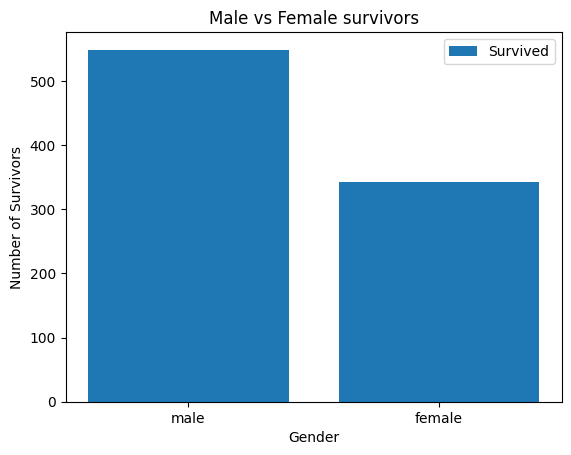

In [456]:
# check the number of survivors with respect to gender 
fig, ax = plt.subplots()
ax.bar(df.Sex.unique(), df.Survived.value_counts(), label='Survived');
ax.set(xlabel='Gender',
       ylabel='Number of Survivors',
       title="Male vs Female survivors")
ax.legend();


In [457]:
df.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


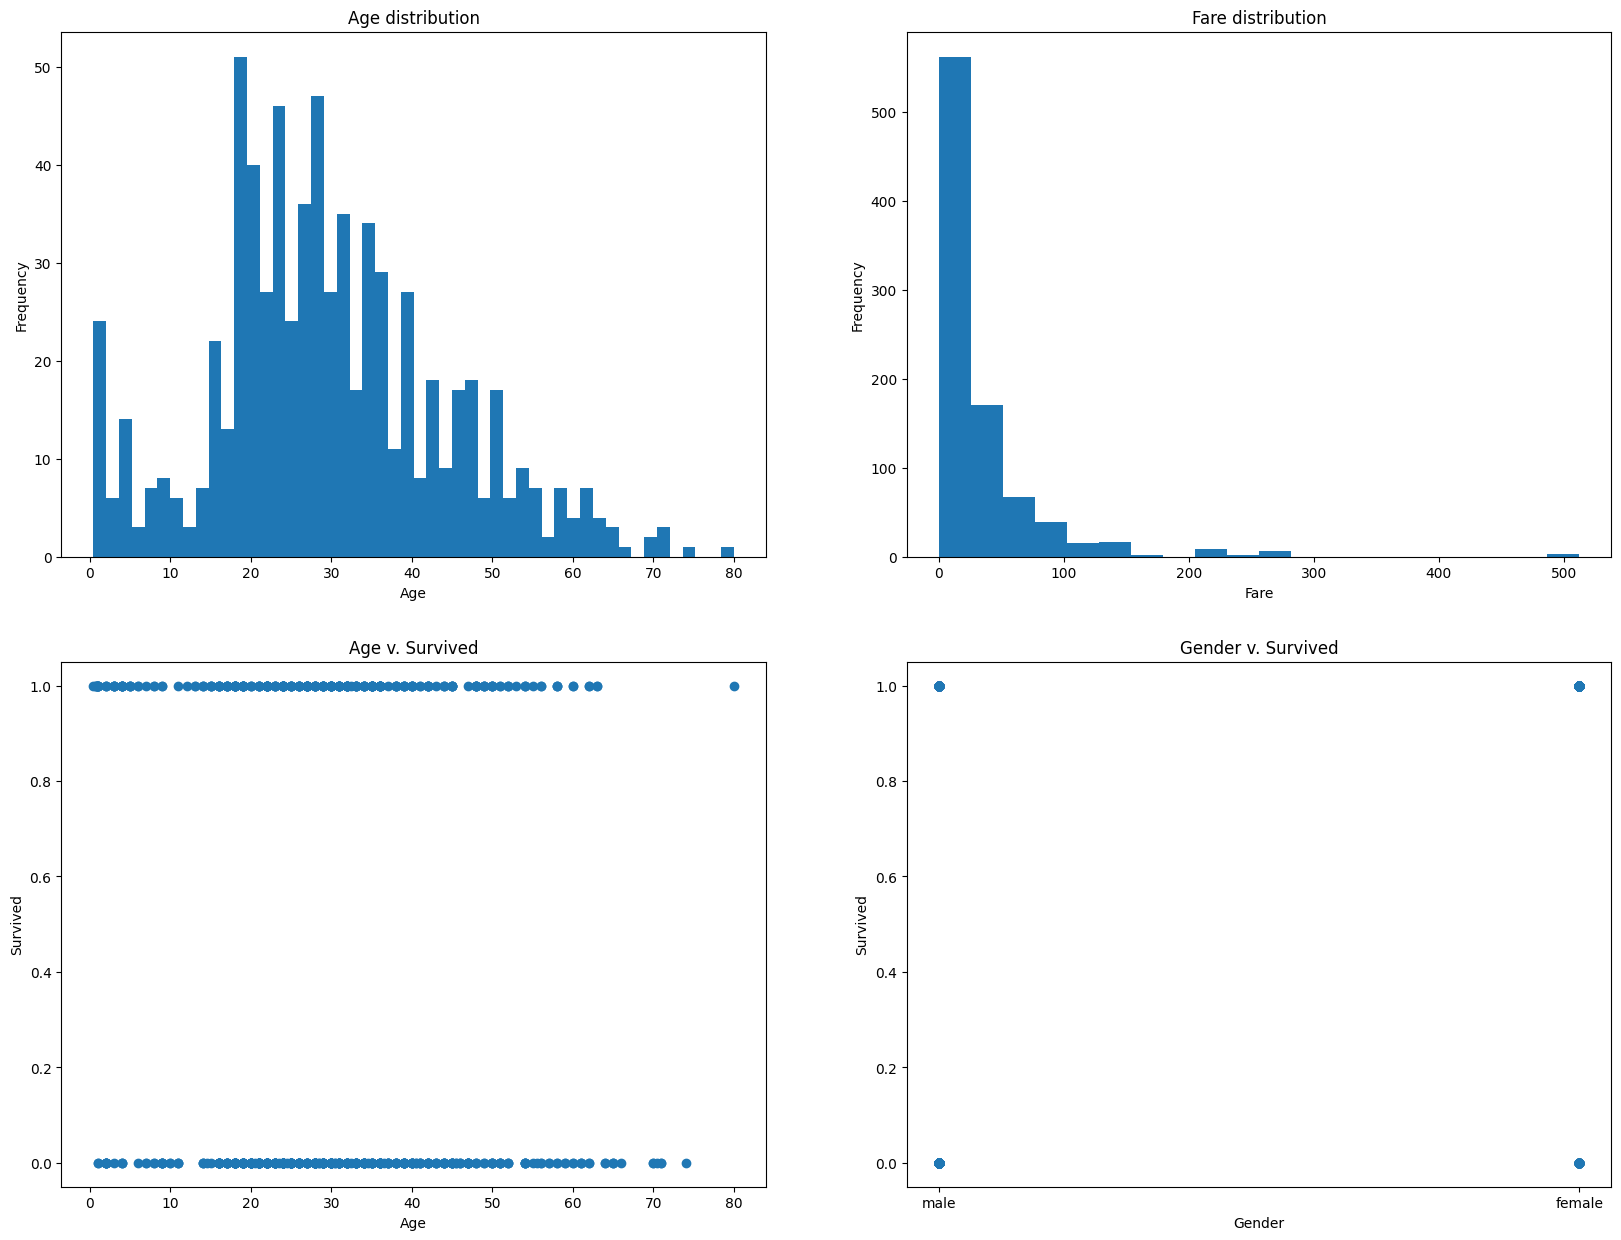

In [458]:
# age distribution, fare distribution, scatter plot between age and survival, gender and survival
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax1.hist(df.Age, bins=50)
ax2.hist(df.Fare, bins=20)
ax3.scatter(df.Age, df.Survived)
ax4.scatter(df.Sex, df.Survived)

ax1.set(title='Age distribution',
        xlabel='Age',
        ylabel='Frequency')

ax2.set(title='Fare distribution',
        xlabel='Fare',
        ylabel='Frequency')

ax3.set(title='Age v. Survived',
        xlabel='Age',
        ylabel='Survived')

ax4.set(title='Gender v. Survived',
        xlabel='Gender',
        ylabel='Survived');


In [459]:
pd.crosstab(df.Sex, df.Survived.value_counts())

count,342,549
Sex,,
female,1,0
male,0,1


## Modelling

In [460]:
# duplicate df
df_mod = df.copy() 
df_mod.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Modelling EDA:  Preprocessing

In [461]:
# re-confirm if there are missing values in the dataset
df_mod.isna().sum() 

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [462]:
for label,content in df_mod.items():
    if content.isna().sum():
        print(label)

Age
Cabin
Embarked


There are missing values in 3 features

#### Address missing values

In [463]:
df_mod.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [464]:
df_mod.Fare.unique().sum()

np.float64(10056.312600000001)

In [465]:
df_mod.Age.isna().sum(), len(df_mod)

(np.int64(177), 891)

Missing values will be filled accordingly:
- Age: Median and indicator column 
- Cabin: 'Missing' and indicator column
- Embarked: 'M' and indicator column 

In [466]:
# fix all missing values
for label,content in df_mod.items():
    if (label=='Age'):
         if pd.isna(content).sum():
                df_mod[label + '_is_missing'] = pd.isna(content)
                df_mod[label] = content.fillna(content.median())
    elif (label=='Cabin'):
         if pd.isna(content).sum():
              df_mod[label + '_is_missing'] = pd.isna(content)
              df_mod[label] = content.fillna('Missing')
    elif (label=='Embarked'):
         if pd.isna(content).sum():
              df_mod[label + '_is_missing'] = pd.isna(content)
              df_mod[label] = content.fillna('M') 

In [467]:
df_mod.isna().sum()

Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                  0
Embarked               0
Age_is_missing         0
Cabin_is_missing       0
Embarked_is_missing    0
dtype: int64

In [468]:
df_mod.Age_is_missing.value_counts(), df_mod.Cabin_is_missing.value_counts(), df_mod.Embarked_is_missing.value_counts()

(Age_is_missing
 False    714
 True     177
 Name: count, dtype: int64,
 Cabin_is_missing
 True     687
 False    204
 Name: count, dtype: int64,
 Embarked_is_missing
 False    889
 True       2
 Name: count, dtype: int64)

Missing values fixed

#### Address Non-numerical data/values

In [469]:
# re-confirm if there are non-numerical data in the dataset 
for label,content in df_mod.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Name
Sex
Ticket
Cabin
Embarked


In [470]:
len(df_mod.Name.unique())

891

In [471]:
df_mod.dtypes 

Survived                 int64
Pclass                   int64
Name                    object
Sex                     object
Age                    float64
SibSp                    int64
Parch                    int64
Ticket                  object
Fare                   float64
Cabin                   object
Embarked                object
Age_is_missing            bool
Cabin_is_missing          bool
Embarked_is_missing       bool
dtype: object

There are 5 features [Name, Sex, Ticket, Cabin, Embarked] that are non-numeric

In [472]:
df_mod.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_is_missing,Cabin_is_missing,Embarked_is_missing
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Missing,S,False,True,False
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,False,False


In [473]:
# re-confirm if there are non-numerical data in the dataset 
for label,content in df_mod.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Name
Sex
Ticket
Cabin
Embarked


Steps to converting non-numerical values to numerical
- `Name`: Extract regular titles, store irregular titles as `other` and put under a column called 'Titles`, then drop the `Name` column - Feature Engineering.
- `Sex`and `Embarked`: convert using pd.get_dummies
- `Cabin`: Create `Deck` feature for decks to avoid high-cardinality, then drop column - Feature Engineering.
- `Ticket`: Convert using Categorical method

#### `Name` (Feature engineering)

In [474]:
df_mod.Name.sample(frac=.2).unique()

array(['Andersson, Miss. Ingeborg Constanzia', 'Mernagh, Mr. Robert',
       'Abbott, Mrs. Stanton (Rosa Hunt)', 'Sjostedt, Mr. Ernst Adolf',
       'Aks, Mrs. Sam (Leah Rosen)', 'Hood, Mr. Ambrose Jr',
       'Clarke, Mrs. Charles V (Ada Maria Winfield)',
       'Vestrom, Miss. Hulda Amanda Adolfina', 'Laleff, Mr. Kristo',
       'Hart, Mr. Henry', 'Bracken, Mr. James H',
       'Goncalves, Mr. Manuel Estanslas', 'Braund, Mr. Lewis Richard',
       'Hansen, Mr. Henry Damsgaard', 'Goodwin, Master. Sidney Leonard',
       'Weir, Col. John', 'Hickman, Mr. Lewis',
       'Jacobsohn, Mr. Sidney Samuel', 'Carlsson, Mr. Frans Olof',
       'Silvey, Mrs. William Baird (Alice Munger)', 'Culumovic, Mr. Jeso',
       'Asplund, Master. Clarence Gustaf Hugo',
       'Brown, Mrs. Thomas William Solomon (Elizabeth Catherine Ford)',
       'Fortune, Miss. Mabel Helen', 'O\'Leary, Miss. Hanora "Norah"',
       'Lines, Miss. Mary Conover', 'McDermott, Miss. Brigdet Delia',
       'Lobb, Mr. William Art

In [475]:
# Extract regular titles form Name feature
titles = ['Mr', 'Mrs', 'Master', 'Miss', 'Dr', 'Rev']

df_mod['Titles'] = df_mod.Name.str.extract(rf'({"|".join(titles)})', expand=False).fillna('Other')

In [476]:
# drop Name column 
df_mod = df_mod.drop('Name', axis=1)

In [477]:
# confirm results
df_mod.sample(frac=.002)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_is_missing,Cabin_is_missing,Embarked_is_missing,Titles
596,1,2,female,28.0,0,0,248727,33.00,Missing,S,True,True,False,Miss
814,0,3,male,30.5,0,0,364499,8.05,Missing,S,False,True,False,Mr


In [478]:
len(df_mod.Titles.unique())

6

In [479]:
# convert Titles feature to numerical 
df_mod = pd.concat([df_mod, pd.get_dummies(df_mod.Titles, prefix='Titles_')], axis=1)

In [480]:
df_mod = df_mod.drop('Titles', axis=1)

In [481]:
df_mod.head(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_is_missing,Cabin_is_missing,Embarked_is_missing,Titles__Dr,Titles__Master,Titles__Miss,Titles__Mr,Titles__Other,Titles__Rev
0,0,3,male,22.0,1,0,A/5 21171,7.25,Missing,S,False,True,False,False,False,False,True,False,False


In [482]:
# re-confirm if there are non-numerical data in the dataset 
for label,content in df_mod.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Sex
Ticket
Cabin
Embarked


#### `Sex` and `Embarked` - pd.get_dummies() 

In [483]:
df_mod = pd.concat([df_mod, pd.get_dummies(df_mod[['Sex', 'Embarked']], prefix=['Sex_', 'Embarked_'])], axis=1)

In [484]:
# drop `Sex` and `Embarked` columns
df_mod = df_mod.drop(columns=['Sex', 'Embarked'], axis=1)

In [485]:
# confirm result
df_mod.head().T

,0,1,2,3,4
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05
Cabin,Missing,C85,Missing,C123,Missing
Age_is_missing,False,False,False,False,False
Cabin_is_missing,True,False,True,False,True


In [486]:
# re-confirm if there are non-numerical data in the dataset 
for label,content in df_mod.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Ticket
Cabin


- `Cabin`: Create `Deck` feature for decks to avoid high-cardinality, then drop column - Feature Engineering.
- `Ticket`: Convert using Categorical method

#### `Cabin` (Feature Engineering)

In [487]:
# check proportion of missing data in the Cabin column
len(df_mod[df_mod.Cabin == 'Missing'])/len(df_mod)*100

77.10437710437711

There are about 80% of missing data/samples in the `Cabin` feature. Normally, I should drop this feature as this is quite much, but for the sake of practise, I will feature engineer this.

In [488]:
# Extract first letter from column values
df_mod['Deck'] = df_mod.Cabin.str.extract(r'([A-Za-z])', expand=False)

In [489]:
# drop Cabin column
df_mod = df_mod.drop('Cabin', axis=1)

In [490]:
# Convert to numerical 
df_mod.Deck.value_counts() 

Deck
M    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [491]:
# replace M with -1
df_mod['Deck'] = df_mod['Deck'].replace('M', -1)

# convert to numerical without ordering
df_mod.Deck = df_mod.Deck.astype('category').cat.codes

In [492]:
# confirm result
df_mod.Age = df_mod.Age.astype('int64')
df_mod.head(2).T 

,0,1
Survived,0,1
Pclass,3,1
Age,22,38
SibSp,1,1
Parch,0,0
Ticket,A/5 21171,PC 17599
Fare,7.25,71.2833
Age_is_missing,False,False
Cabin_is_missing,True,False
Embarked_is_missing,False,False


In [493]:
# re-confirm if there are non-numerical data in the dataset 
for label,content in df_mod.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Ticket


- `Ticket`: Convert using Categorical method

#### `Ticket` - Categorical 


In [494]:
# convert to categorical data and order
df_mod.Ticket = df_mod['Ticket'].astype('category').cat.as_ordered()

# convert to numerical
df_mod.Ticket = df_mod['Ticket'].cat.codes

In [495]:
# confirm result
df_mod.head(1).T

,0
Survived,0
Pclass,3
Age,22
SibSp,1
Parch,0
Ticket,523
Fare,7.25
Age_is_missing,False
Cabin_is_missing,True
Embarked_is_missing,False


In [496]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Survived             891 non-null    int64  
 1   Pclass               891 non-null    int64  
 2   Age                  891 non-null    int64  
 3   SibSp                891 non-null    int64  
 4   Parch                891 non-null    int64  
 5   Ticket               891 non-null    int16  
 6   Fare                 891 non-null    float64
 7   Age_is_missing       891 non-null    bool   
 8   Cabin_is_missing     891 non-null    bool   
 9   Embarked_is_missing  891 non-null    bool   
 10  Titles__Dr           891 non-null    bool   
 11  Titles__Master       891 non-null    bool   
 12  Titles__Miss         891 non-null    bool   
 13  Titles__Mr           891 non-null    bool   
 14  Titles__Other        891 non-null    bool   
 15  Titles__Rev          891 non-null    boo

In [497]:
pd.api.types.is_object_dtype(df_mod), pd.api.types.is_string_dtype(df_mod)

(False, False)

### Modelling

In [498]:
df_mod.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Age_is_missing', 'Cabin_is_missing', 'Embarked_is_missing',
       'Titles__Dr', 'Titles__Master', 'Titles__Miss', 'Titles__Mr',
       'Titles__Other', 'Titles__Rev', 'Sex__female', 'Sex__male',
       'Embarked__C', 'Embarked__M', 'Embarked__Q', 'Embarked__S', 'Deck'],
      dtype='object')

In [499]:
# split data into train and validation sets

X = df_mod.drop('Survived', axis=1) # training set
y = df_mod['Survived'] # validation set

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=12, stratify=y)

In [500]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape 

((712, 22), (179, 22), (712,), (179,))

In [501]:
X_valid.head()

,Pclass,Age,SibSp,Parch,Ticket,Fare,Age_is_missing,Cabin_is_missing,Embarked_is_missing,Titles__Dr,...,Titles__Mr,Titles__Other,Titles__Rev,Sex__female,Sex__male,Embarked__C,Embarked__M,Embarked__Q,Embarked__S,Deck
691,3,4,0,1,393,13.4167,False,True,False,False,...,False,False,False,True,False,True,False,False,False,0
43,2,3,1,2,634,41.5792,False,True,False,False,...,False,False,False,True,False,True,False,False,False,0
666,2,25,0,0,123,13.0000,False,True,False,False,...,True,False,False,False,True,False,False,False,True,0
769,3,32,0,0,511,8.3625,False,True,False,False,...,True,False,False,False,True,False,False,False,True,0
419,3,10,0,2,307,24.1500,False,True,False,False,...,False,False,False,True,False,False,False,False,True,0


In [502]:
df_mod.shape 

(891, 23)

In [503]:
df_mod.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [504]:
'''
Since it's a classification problem, selected suitable models:
- RandomForestClassifier()
- XGBoost() - refine/improve metric score 
- Catboost()

Hyper-parameter Tunning
- RandomSearchCV - baseline
- GridSearchCV - refine tuning
- Optuna ()
''' 

"\nSince it's a classification problem, selected suitable models:\n- RandomForestClassifier()\n- XGBoost() - refine/improve metric score \n- Catboost()\n\nHyper-parameter Tunning\n- RandomSearchCV - baseline\n- GridSearchCV - refine tuning\n- Optuna ()\n"

In [505]:
models = {
    'RF' : RandomForestClassifier(random_state=12,
                                  n_estimators=100,
                                  max_depth=10,
                                  min_samples_split=5,
                                  min_samples_leaf=2,
                                  max_features='sqrt',
                                  n_jobs=-1),
    'XGB' : xgb.XGBClassifier(eval_metric='logloss', 
                              random_state=12,
                              n_estimators=100,
                              max_depth=6,
                              learning_rate=0.1,
                              subsample=0.8,
                              colsample_bytree=.8,
                              reg_alpha=.1,
                              reg_lambda=1),
    'CatBoost' : cat.CatBoostClassifier(verbose=0, 
                                        iterations=200, 
                                        random_state=12,
                                        depth=6,
                                        learning_rate=.1,
                                        l2_leaf_reg=3.0,
                                        random_strength=1.0,
                                        thread_count=-1
                                        ),
    'LinearSVC': LinearSVC(random_state=12,
                           C=1,
                           penalty='l2',
                           loss='squared_hinge',
                           max_iter=2000)
}

results = {}
for name, model in models.items():
    # preprocess if needed (scale for SVC)
    if name in ['LinearSVC']:
        scaler = StandardScaler() 
        X_train_mod = scaler.fit_transform(X_train)
        X_valid_mod = scaler.transform(X_valid)
    else: 
        X_train_mod, X_valid_mod = X_train, X_valid 
    
    model.fit(X_train_mod, y_train)
    preds = model.predict(X_valid_mod)
    results[name] = accuracy_score(y_valid, preds)
    print(f'{name}: {results[name]:.4f}')


RF: 0.7989
XGB: 0.8324
CatBoost: 0.8380
LinearSVC: 0.8156


From the results above it is clear the the top 2 most promising models are RF and CatBoost, let's however quickly tune LinearSVC to see if it holds any promise before eliminating it.

In [506]:
SVC_baseline = LinearSVC()

param_dist = {'C':np.arange(.1,5),
              'penalty':['l1', 'l2'],
              'loss':['squared_hinge'],
              'dual':[False],
              'max_iter':np.arange(100,2000,100)}

cv_svc = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
rs_svc = RandomizedSearchCV(SVC_baseline,
                            param_distributions=param_dist,
                            cv=cv_svc,
                            n_iter=10,
                            n_jobs=-1,
                            scoring='accuracy',
                            verbose=True,
                            random_state=12)

scaler = StandardScaler()
X_train_svc = scaler.fit_transform(X_train)
X_valid_svc = scaler.transform(X_valid)

rs_svc.fit(X_train_svc, y_train)
y_preds_svc = rs_svc.predict(X_valid_svc)
score_svc = accuracy_score(y_valid, y_preds_svc)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [507]:
score_svc

0.8100558659217877

In [508]:
rs_svc.best_params_

{'penalty': 'l2',
 'max_iter': np.int64(600),
 'loss': 'squared_hinge',
 'dual': False,
 'C': np.float64(0.1)}

Tune with Optuna

In [509]:
def objective(trial):
    params={'penalty':trial.suggest_categorical('penalty',['l1', 'l2']),
            'max_iter':trial.suggest_int('max_iter', 100,10000),
            'loss':trial.suggest_categorical('loss', ['squared_hinge']),
            'dual':trial.suggest_categorical('dual', [False]),
            'C':trial.suggest_float('C',.1, 30)
           }
    
    ideal_svc = LinearSVC(**params, random_state=12)

    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
    score = cross_val_score(ideal_svc,
                            X_train_svc, 
                            y_train,
                            cv=cv,
                            scoring='accuracy').mean()
    
    return score 
    
# create study
study = opt.create_study(direction='maximize')

# optimize study
study.optimize(objective, n_trials=30)

best_score_svc = study.best_value 
best_param_svc = study.best_params 

print(f'Best_score = {best_score_svc} \n Best_params = {best_param_svc}')

opt.visualization.plot_optimization_history(study).show()

[I 2025-10-02 19:45:57,231] A new study created in memory with name: no-name-6296481c-e8a7-426c-9938-9e3810010e2d
c:\ProgramData\Miniconda3\envs\ML\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\ProgramData\Miniconda3\envs\ML\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\ProgramData\Miniconda3\envs\ML\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\ProgramData\Miniconda3\envs\ML\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\ProgramData\Miniconda3\envs\ML\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

[I 2025-10-02 19:45:58,239] Trial 0 finished with value:

Best_score = 0.8271840835221116 
 Best_params = {'penalty': 'l1', 'max_iter': 2124, 'loss': 'squared_hinge', 'dual': False, 'C': 19.605449074351846}


Having tried to tune `LinearSVC` with RandomizedSearchCV and Optuna with the best score being `82`% it's best to drop it and move to morre promising models

### Hyper-parameter Tuning to improve score
1. With RandomizedSearchCV

In [510]:
# Tune CatBoost and RandomizedForestClassifier with Randomized CV

clf_rs = RandomForestClassifier(random_state=12)
cat_rs = cat.CatBoostClassifier(random_state=12)

models = {'clf': clf_rs,
          'cat': cat_rs}

clf_rs_param = {
    'n_estimators':list(range(100,300,50)),
    'max_depth':list(range(3,10)),
    'min_samples_leaf': list(range(5,20)),
    'min_samples_split': list(range(5,20)),
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_features':['sqrt', 'log2', None],
    'max_leaf_nodes':list(range(20,100)),
    'min_weight_fraction_leaf': np.random.uniform(.0, .05, size=60).tolist()
}

cat_rs_param = {
    'iterations':np.arange(100,500,50).tolist(),
    'learning_rate':np.random.uniform(.05,.1, size=20).tolist(),
    'depth':np.arange(4,10).tolist(),
    'l2_leaf_reg':np.arange(1,10).tolist(),
    'subsample': np.random.uniform(.5, 1, size=20).tolist()
}

# RandomizedSearchCV function
def r_search(model, params):

    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

    r_model = RandomizedSearchCV(
        model,
        param_distributions=params,
        cv = cv,
        n_iter=20,
        scoring='accuracy',
        verbose=1,
        random_state=12,
        n_jobs=-1
    )

    r_model.fit(X_train, y_train)
    y_preds = r_model.predict(X_valid)
    score = accuracy_score(y_valid, y_preds)
    return score, f'model best parameters = {r_model.best_params_}'

In [511]:
X_train.head().T 

,802,541,356,250,522
Pclass,1,3,1,3,3
Age,11,9,22,28,28
SibSp,1,4,0,0,0
Parch,2,2,1,0,0
Ticket,33,333,28,422,173
Fare,120.0,31.275,55.0,7.25,7.225
Age_is_missing,False,False,False,True,True
Cabin_is_missing,False,True,False,True,True
Embarked_is_missing,False,False,False,False,False
Titles__Dr,False,False,False,False,False


In [512]:
r_search(cat_rs, cat_rs_param)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0:	learn: 0.6379624	total: 31.4ms	remaining: 10.9s
1:	learn: 0.5961812	total: 33.6ms	remaining: 5.85s
2:	learn: 0.5598445	total: 36ms	remaining: 4.16s
3:	learn: 0.5347071	total: 38.2ms	remaining: 3.31s
4:	learn: 0.5107493	total: 40.6ms	remaining: 2.8s
5:	learn: 0.4905010	total: 42.9ms	remaining: 2.46s
6:	learn: 0.4790336	total: 46.2ms	remaining: 2.26s
7:	learn: 0.4697613	total: 48.6ms	remaining: 2.08s
8:	learn: 0.4551886	total: 51ms	remaining: 1.93s
9:	learn: 0.4444175	total: 53.5ms	remaining: 1.82s
10:	learn: 0.4375330	total: 67.5ms	remaining: 2.08s
11:	learn: 0.4294348	total: 70.3ms	remaining: 1.98s
12:	learn: 0.4250365	total: 72.7ms	remaining: 1.89s
13:	learn: 0.4174387	total: 75.1ms	remaining: 1.8s
14:	learn: 0.4114292	total: 78.5ms	remaining: 1.75s
15:	learn: 0.4049163	total: 80.9ms	remaining: 1.69s
16:	learn: 0.4029125	total: 83.2ms	remaining: 1.63s
17:	learn: 0.3993205	total: 85.5ms	remaining: 1.58s
18:	learn: 0.39613

(0.8212290502793296,
 "model best parameters = {'subsample': 0.6907703920918711, 'learning_rate': 0.09548248168621205, 'l2_leaf_reg': 8, 'iterations': 350, 'depth': 4}")

In [513]:
rs_cat_best_params = {'subsample': 0.6485771921664951, 'learning_rate': 0.08266168342627189, 'l2_leaf_reg': 4, 'iterations': 200, 'depth': 4}
rs_cat_best_params 

{'subsample': 0.6485771921664951,
 'learning_rate': 0.08266168342627189,
 'l2_leaf_reg': 4,
 'iterations': 200,
 'depth': 4}

In [514]:
r_search(clf_rs, clf_rs_param)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


(0.776536312849162,
 "model best parameters = {'n_estimators': 150, 'min_weight_fraction_leaf': 0.029476566567042502, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_leaf_nodes': 76, 'max_features': None, 'max_depth': 5, 'criterion': 'log_loss'}")

In [515]:
rs_clf_best_params = {'n_estimators': 150, 'min_weight_fraction_leaf': 0.012389209638971067, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_leaf_nodes': 39, 'max_features': 'log2', 'max_depth': 7, 'criterion': 'gini'}
rs_clf_best_params

{'n_estimators': 150,
 'min_weight_fraction_leaf': 0.012389209638971067,
 'min_samples_split': 11,
 'min_samples_leaf': 5,
 'max_leaf_nodes': 39,
 'max_features': 'log2',
 'max_depth': 7,
 'criterion': 'gini'}

Having ran searches using RandomSearchCV to get baseline parameters, GridSearchCV is used to narrow the tunable parameters for the best parameters.

Score with RandomSearch parameters for each model:
- CatBoost (score=0.8212290502793296):
> - 'subsample': 0.6485771921664951,
> - 'learning_rate': 0.08266168342627189,
> - 'l2_leaf_reg': 4,
> - 'iterations': 200,
> - 'depth': 4

- RandomForest (score=0.776536312849162):
> - 'n_estimators': 150,
> - 'min_weight_fraction_leaf': 0.012389209638971067,
> - 'min_samples_split': 11,
> - 'min_samples_leaf': 5,
> - 'max_leaf_nodes': 39,
> - 'max_features': 'log2',
> - 'max_depth': 7,
> - 'criterion': 'gini'

In [ ]:
cat_rs_score = 0.8212290502793296
clf_rs_score = 0.776536312849162

2. GridSearchCV Tuning

In [517]:
# grid parameters for each model using the best parameters for each derived from previous search

clf_gs = RandomForestClassifier(random_state=12)
cat_gs = cat.CatBoostClassifier(random_state=12)

# grid search parameters
clf_gs_param = {
    'n_estimators':[100,150,200],
    'max_depth': [6,7,8],
    'min_samples_leaf': [4,5,6],
    'min_samples_split': [10,11,12],
    'criterion': ['gini'],
    'max_features': ['log2'],
    'max_leaf_nodes': [37,39,40],
    'min_weight_fraction_leaf': [0.012]
}

# catboost parameters
cat_gs_param = {
    'iterations': [200],
    'learning_rate': [.08],
    'depth': [3,4,5],
    'l2_leaf_reg': [5,6],
    'subsample': [.65],
}

def g_search(model, param):

    # create stratified CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

    # create model for g_search
    gs_model = GridSearchCV(model,
                            param_grid=param,
                            cv=cv,
                            n_jobs=-1,
                            verbose=1,
                            scoring='accuracy'
                            )
    
    gs_model.fit(X_train, y_train)
    y_preds = gs_model.predict(X_valid)
    g_score = accuracy_score(y_valid, y_preds)
    g_best_params = gs_model.best_params_

    return g_score, f'Best parameters = {g_best_params}'

In [518]:
# GridSearch for catboost
g_search(cat_gs, cat_gs_param)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0:	learn: 0.6402203	total: 3.72ms	remaining: 740ms
1:	learn: 0.6166518	total: 5.67ms	remaining: 562ms
2:	learn: 0.5773268	total: 9.6ms	remaining: 630ms
3:	learn: 0.5498023	total: 12.6ms	remaining: 617ms
4:	learn: 0.5245827	total: 16.3ms	remaining: 637ms
5:	learn: 0.5077860	total: 18.9ms	remaining: 610ms
6:	learn: 0.4892598	total: 21.5ms	remaining: 592ms
7:	learn: 0.4786334	total: 23.6ms	remaining: 565ms
8:	learn: 0.4653758	total: 26.2ms	remaining: 555ms
9:	learn: 0.4497745	total: 28.9ms	remaining: 550ms
10:	learn: 0.4390568	total: 32.7ms	remaining: 562ms
11:	learn: 0.4337277	total: 35.3ms	remaining: 554ms
12:	learn: 0.4253130	total: 37.9ms	remaining: 546ms
13:	learn: 0.4168998	total: 40.6ms	remaining: 540ms
14:	learn: 0.4103113	total: 43.3ms	remaining: 534ms
15:	learn: 0.4039990	total: 46.8ms	remaining: 539ms
16:	learn: 0.4028570	total: 48.9ms	remaining: 526ms
17:	learn: 0.3980145	total: 51.5ms	remaining: 520ms
18:	learn: 0.39

(0.8156424581005587,
 "Best parameters = {'depth': 5, 'iterations': 200, 'l2_leaf_reg': 6, 'learning_rate': 0.08, 'subsample': 0.65}")

In [ ]:
cat_gs_score = 0.8156424581005587
cat_gs_best_params = {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 6, 'learning_rate': 0.08, 'subsample': 0.65}

In [520]:
# GridSearch for RF 
g_search(clf_gs, clf_gs_param)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


(0.8100558659217877,
 "Best parameters = {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'max_leaf_nodes': 37, 'min_samples_leaf': 5, 'min_samples_split': 11, 'min_weight_fraction_leaf': 0.012, 'n_estimators': 200}")

In [ ]:
clf_gs_score = 0.8100558659217877
clf_gs_best_params = {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'max_leaf_nodes': 37, 'min_samples_leaf': 4, 'min_samples_split': 11, 'min_weight_fraction_leaf': 0.012, 'n_estimators': 100} 

3. Optuna Parameter Tuning

In [522]:
clf_gs_best_params 

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'max_leaf_nodes': 37,
 'min_samples_leaf': 4,
 'min_samples_split': 11,
 'min_weight_fraction_leaf': 0.012,
 'n_estimators': 100}

In [ ]:
# Optuna tuning for RandomizedSearch
def objectives(trial):
    r_params = {
        'n_estimators': trial.suggest_int('n_estimators', 200,500),
        'criterion':trial.suggest_categorical('criterion',['gini']),
        'max_depth':trial.suggest_int('max_depth', 8,10),
        'max_features':trial.suggest_categorical('max_features', ['log2']),
        'max_leaf_nodes':trial.suggest_int('max_leaf_nodes',37,38), # 37 default
        'min_samples_leaf':trial.suggest_int('min_samples_leaf',4,5), # 4 default
        'min_samples_split':trial.suggest_int('min_samples_split',11,12)# 11 default)
    }

    # instantiate model 
    clf_opt = RandomForestClassifier(**r_params, random_state=12, min_weight_fraction_leaf=0.012) 

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

    # score 
    score = cross_val_score(clf_opt,
                            X_train,
                            y_train,
                            cv=cv,
                            scoring='accuracy'
                            ).mean()
    
    return score

# create study
study = opt.create_study(direction='maximize')

# optimize study
study.optimize(objectives, n_trials=40)

# return metrics 
clf_opt_score = study.best_value
clf_opt_params = study.best_params

print(f'Accuracy for RF = {clf_opt_score}, \n Best parameters = {clf_opt_params}')

opt.visualization.plot_optimization_history(study).show()


[I 2025-10-02 19:53:33,508] A new study created in memory with name: no-name-26d5cca3-8872-457e-9dd9-6556b467197a
[I 2025-10-02 19:53:36,491] Trial 0 finished with value: 0.8173840244262779 and parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'max_leaf_nodes': 37, 'min_samples_leaf': 4, 'min_samples_split': 11}. Best is trial 0 with value: 0.8173840244262779.
[I 2025-10-02 19:53:38,609] Trial 1 finished with value: 0.8117600709150004 and parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': 37, 'min_samples_leaf': 5, 'min_samples_split': 12}. Best is trial 0 with value: 0.8173840244262779.
[I 2025-10-02 19:53:40,387] Trial 2 finished with value: 0.814586821629075 and parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': 38, 'min_samples_leaf': 4, 'min_samples_split': 12}. Best is trial 0 with value: 0.8173840244262779.
[I 2025-10-02 19:53:42,439] Trial 3 finished with value: 0.81176007

Accuracy for RF = 0.8229981286319313, 
 Best parameters = {'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': 38, 'min_samples_leaf': 4, 'min_samples_split': 11}


In [588]:
clf_opt_params

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'log2',
 'max_leaf_nodes': 38,
 'min_samples_leaf': 4,
 'min_samples_split': 11}

From the plots, it can be seen that after 20 trials, the objective value doesn't seem to increase further, so no need to increase trials.

In [581]:
# Optuna tuning for CatBoost
def objectives(trial):
    cat_params = {
        'depth':trial.suggest_int('depth',4,10), # 4, 5
        'iterations':trial.suggest_int('iterations',200,1000), # 200, 300
        'l2_leaf_reg':trial.suggest_int('l2_leaf_reg',6,7), # 6,7
        'learning_rate':trial.suggest_float('learning_rate',.03,.08, log=True), #.08,.09
    }

    # instantiate model 
    cat_opt = cat.CatBoostClassifier(**cat_params, verbose=False, eval_metric='Accuracy', random_state=12) 

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

    # score 
    score = cross_val_score(cat_opt,
                            X_train,
                            y_train,
                            cv=cv,
                            scoring='accuracy',
                            error_score='raise'
                            ).mean()
    
    return score

# create study
study = opt.create_study(direction='maximize')

# optimize study
study.optimize(objectives, n_trials=50)

# return metrics 
cat_opt_score = study.best_value
cat_opt_params = study.best_params

print(f'Accuracy = {cat_opt_score}, \n Best parameters = {cat_opt_params}')

opt.visualization.plot_optimization_history(study).show()


[I 2025-10-02 20:30:27,923] A new study created in memory with name: no-name-ffaa8299-180e-4c2c-944b-c2355dbf5cdd
[I 2025-10-02 20:30:49,038] Trial 0 finished with value: 0.8356741849699596 and parameters: {'depth': 7, 'iterations': 462, 'l2_leaf_reg': 6, 'learning_rate': 0.03214407337301158}. Best is trial 0 with value: 0.8356741849699596.
[I 2025-10-02 20:31:13,072] Trial 1 finished with value: 0.8427164384910864 and parameters: {'depth': 5, 'iterations': 894, 'l2_leaf_reg': 6, 'learning_rate': 0.05343366827437811}. Best is trial 1 with value: 0.8427164384910864.
[I 2025-10-02 20:31:42,586] Trial 2 finished with value: 0.8483403920023639 and parameters: {'depth': 6, 'iterations': 945, 'l2_leaf_reg': 7, 'learning_rate': 0.0332568608790467}. Best is trial 2 with value: 0.8483403920023639.
[I 2025-10-02 20:32:01,323] Trial 3 finished with value: 0.8399093863882596 and parameters: {'depth': 7, 'iterations': 491, 'l2_leaf_reg': 6, 'learning_rate': 0.04281418031866742}. Best is trial 2 wit

Accuracy = 0.8553530976066188, 
 Best parameters = {'depth': 4, 'iterations': 676, 'l2_leaf_reg': 7, 'learning_rate': 0.03190625666400382}


In [ ]:
cat_opt_params

{'depth': 4,
 'iterations': 676,
 'l2_leaf_reg': 7,
 'learning_rate': 0.03190625666400382}

In [583]:
cat_par = cat_opt_params
cat_par['accuracy'] = float(np.round(0.8553530976066188,3))
cat_par 

{'depth': 4,
 'iterations': 676,
 'l2_leaf_reg': 7,
 'learning_rate': 0.03190625666400382,
 'accuracy': 0.855}

In [584]:
cat_opt_results.loc[2]= cat_par

In [585]:
# cat_opt_results = pd.DataFrame([cat])
cat_opt_results 

,depth,iterations,l2_leaf_reg,learning_rate,accuracy
0,4,365,7,0.088549,0.854
1,4,251,6,0.098660,0.851
2,4,676,7,0.031906,0.855


So, after about 6-7 trainings with parameter tuning via Optuna, I have recorded the last 4 and observed the score has converged at ~85% accuracy. Now, I will proceed to do a final run using `votingClassifier`

#### Final model

In [587]:
# create new dictionary with best params for catboost 
cat_opt_params_main = {'depth': 4,
 'iterations': 676,
 'l2_leaf_reg': 7,
 'learning_rate': 0.03190625666400382} 

cat_opt_params_main

{'depth': 4,
 'iterations': 676,
 'l2_leaf_reg': 7,
 'learning_rate': 0.03190625666400382}

In [589]:
from sklearn.ensemble import VotingClassifier 

# instantiate models with best parameters
clf_best = RandomForestClassifier(**clf_opt_params, random_state=12)
cat_best = cat.CatBoostClassifier(**cat_opt_params_main, random_state=12, verbose=False)

# create ensembles 
ensemble = VotingClassifier(estimators=[('rf', clf_best), ('cat',cat_best)],
                            voting='soft',
                            verbose=False
    )

# list of models to evaluate 
models = [('clf_best', clf_best), 
          ('cat_best', cat_best), 
          ('ensemble', ensemble)]


def final_scores(models):
    
    for name,model in models:
        model.fit(X_train,y_train)
        yy_preds = model.predict(X_valid)
        score = accuracy_score(y_valid, yy_preds)
        print(f'{name:15} accuracy = {score:.3f}')

In [590]:
final_scores(models)

clf_best        accuracy = 0.821
cat_best        accuracy = 0.821
ensemble        accuracy = 0.832


#### Create final models for submission

In [591]:
# final training data
X_train_final = pd.concat([X_train, X_valid], axis=0) 
y_train_final = pd.concat([y_train, y_valid], axis=0) 


#### Import test data

In [592]:
# import test (features only) data and check cleanliness and compatibility
X_test_origin = pd.read_csv('data/test.csv')
X_test_origin.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [593]:
# drop `PassengerID`
X_test_df = X_test_origin.drop('PassengerId', axis=1)

In [594]:
X_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB


In [595]:
X_test_df.shape, X_train_final.shape 

((418, 10), (891, 22))

In [596]:
# list names of columns with missing values
for name, content in X_test_df.items():
    if pd.isnull(content).sum():
        print(name)

Age
Fare
Cabin


In [597]:
# list columns with non-numerical entries/samples
for name, content in X_test_df.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(name)

Name
Sex
Ticket
Cabin
Embarked


The X_test data needs some preprocessing before making predictions

#### fix missing values 

In [598]:
# fix all missing values
for label,content in X_test_df.items():
    if (label=='Age'):
         if pd.isna(content).sum():
                X_test_df[label + '_is_missing'] = pd.isna(content)
                X_test_df[label] = content.fillna(content.median())
    elif (label=='Cabin'):
         if pd.isna(content).sum():
              X_test_df[label + '_is_missing'] = pd.isna(content)
              X_test_df[label] = content.fillna('Missing')
    elif (label=='Fare'):
         if pd.isna(content).sum():
              X_test_df[label] = content.fillna(content.median()) 


In [599]:
# create a `Embarked_is_missing` column for test data.
X_test_df['Embarked_is_missing'] = False 

In [600]:
# check 
X_train_final.head().T 

,802,541,356,250,522
Pclass,1,3,1,3,3
Age,11,9,22,28,28
SibSp,1,4,0,0,0
Parch,2,2,1,0,0
Ticket,33,333,28,422,173
Fare,120.0,31.275,55.0,7.25,7.225
Age_is_missing,False,False,False,True,True
Cabin_is_missing,False,True,False,True,True
Embarked_is_missing,False,False,False,False,False
Titles__Dr,False,False,False,False,False


In [601]:
# rename columns to remove the leading '_' 
X_train_final = X_train_final.rename(columns={'_Titles_Dr': 'Titles_Dr',
                                       '_Titles_Master': 'Titles_Master',
                                       '_Titles_Miss': 'Titles_Miss',
                                       '_Titles_Mr': 'Titles_Mr',
                                       '_Titles_Other': 'Titles_Other',
                                       '_Titles_Rev': 'Titles_Rev'})

In [602]:
# check
X_test_df.head().T 

,0,1,2,3,4
Pclass,3,3,2,3,3
Name,"Kelly, Mr. James","Wilkes, Mrs. James (Ellen Needs)","Myles, Mr. Thomas Francis","Wirz, Mr. Albert","Hirvonen, Mrs. Alexander (Helga E Lindqvist)"
Sex,male,female,male,male,female
Age,34.5,47.0,62.0,27.0,22.0
SibSp,0,1,0,0,1
Parch,0,0,0,0,1
Ticket,330911,363272,240276,315154,3101298
Fare,7.8292,7.0,9.6875,8.6625,12.2875
Cabin,Missing,Missing,Missing,Missing,Missing
Embarked,Q,S,Q,S,S


In [603]:
# confirm there are no missing values 
X_test_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Pclass               418 non-null    int64  
 1   Name                 418 non-null    object 
 2   Sex                  418 non-null    object 
 3   Age                  418 non-null    float64
 4   SibSp                418 non-null    int64  
 5   Parch                418 non-null    int64  
 6   Ticket               418 non-null    object 
 7   Fare                 418 non-null    float64
 8   Cabin                418 non-null    object 
 9   Embarked             418 non-null    object 
 10  Age_is_missing       418 non-null    bool   
 11  Cabin_is_missing     418 non-null    bool   
 12  Embarked_is_missing  418 non-null    bool   
dtypes: bool(3), float64(2), int64(3), object(5)
memory usage: 34.0+ KB


#### fix non-numerical values 

In [604]:
# fix name 
# Extract regular titles form Name feature
titles = ['Mr', 'Mrs', 'Master', 'Miss', 'Dr', 'Rev']

X_test_df['Titles'] = X_test_df.Name.str.extract(rf'({"|".join(titles)})', expand=False).fillna('Other')

In [605]:
# drop Name column 
X_test_df = X_test_df.drop('Name', axis=1)

In [606]:
# convert Titles feature to numerical 
X_test_df = pd.concat([X_test_df, pd.get_dummies(X_test_df.Titles, prefix='Titles_')], axis=1)

In [607]:
# drop the `Titles` column
X_test_df = X_test_df.drop('Titles', axis=1)

In [608]:
# fix `Sex` and `Embarked` column
X_test_df = pd.concat([X_test_df, pd.get_dummies(X_test_df[['Sex', 'Embarked']], prefix=['Sex_', 'Embarked_'])], axis=1)

In [609]:
# drop `Sex` and `Embarked` columns
X_test_df = X_test_df.drop(columns=['Sex', 'Embarked'], axis=1)

In [610]:
# fix `Cabin` 
# Extract first letter from column values
X_test_df['Deck'] = X_test_df.Cabin.str.extract(r'([A-Za-z])', expand=False)

In [611]:
# drop Cabin column
X_test_df = X_test_df.drop('Cabin', axis=1)

In [612]:
# replace M with -1
X_test_df['Deck'] = X_test_df['Deck'].replace('M', -1)

# convert to numerical without ordering
X_test_df.Deck = X_test_df.Deck.astype('category').cat.codes

In [613]:
# convert `Age` to integer
X_test_df.Age = X_test_df.Age.astype('int64')

In [614]:
# fix `Ticket` category 
# convert to categorical data and order
X_test_df.Ticket = X_test_df['Ticket'].astype('category').cat.as_ordered()

# convert to numerical
X_test_df.Ticket = X_test_df['Ticket'].cat.codes

In [615]:
X_test_df.shape, X_train_final.shape 

((418, 21), (891, 22))

In [616]:
# create the `Embarked_M` column  
X_test_df['Embarked_M'] = False  

In [617]:
# drop `PassengerID`


In [618]:
X_train_final.head().T 

,802,541,356,250,522
Pclass,1,3,1,3,3
Age,11,9,22,28,28
SibSp,1,4,0,0,0
Parch,2,2,1,0,0
Ticket,33,333,28,422,173
Fare,120.0,31.275,55.0,7.25,7.225
Age_is_missing,False,False,False,True,True
Cabin_is_missing,False,True,False,True,True
Embarked_is_missing,False,False,False,False,False
Titles__Dr,False,False,False,False,False


In [619]:
X_test_df.head().T 

,0,1,2,3,4
Pclass,3,3,2,3,3
Age,34,47,62,27,22
SibSp,0,1,0,0,1
Parch,0,0,0,0,1
Ticket,152,221,73,147,138
Fare,7.8292,7.0,9.6875,8.6625,12.2875
Age_is_missing,False,False,False,False,False
Cabin_is_missing,True,True,True,True,True
Embarked_is_missing,False,False,False,False,False
Titles__Dr,False,False,False,False,False


In [620]:
X_test_final = X_test_df

In [621]:
# final test data
X_train_final, X_test_final = X_train_final.align(X_test_final, 
                                                  join='outer',
                                                  axis=1,
                                                  fill_value=0)

In [622]:
X_train_final.shape, X_test_final.shape 

((891, 23), (418, 23))

In [623]:
# final training
ensemble.fit(X_train_final, y_train_final)
y_preds_final = ensemble.predict(X_test_final)

In [624]:
# create submission
submission = pd.DataFrame({
    'PassengerId': X_test_origin['PassengerId'],
    'Survived': y_preds_final.astype(int)
})

# save submission
submission.to_csv('Submission.csv', index=False)

In [625]:
submission.head() 

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


### to do next time
- Create feature importance
- write ReadMe (add picture)
- Final notes (coonclusion)